**GAN based random text generator**

GAN is well known for it's non-discrete data generation abilities.<br>
In this notebook I'll adapt and train GAN for text generation(based on [LaText GAN](https://arxiv.org/pdf/1810.06640.pdf)). 

First, let's create data loader with tokenizer.

In [17]:
import re
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


class DataLoader:

    def __init__(self, src_csv="", src_column='', sentence_len=100, num_words=10000):
        self.__src_csv = src_csv  # source csv file with test data
        self.__src_column = src_column # column name in source file
        self.__sentence_len = sentence_len  # max sentence length
        self.__num_words = num_words  # number of most frequent words to keep
        self.__tokenizer = None # tokenizer
        self.sentences = []  # text data
        self.sequences = np.array([])  # indexed data from tokenizer

    def __load_file(self):
        df = pd.read_csv(self.__src_csv, keep_default_na=False) 
        self.sentences = [re.sub(r"<.*?>", " ", x) for x in df['review']]  # remove html tags
        self.sentences = [s.replace('.', ' .') for s in self.sentences] # let's keep period
        # rest of data cleaning is done by tokenizer

    def __init_tokenizer(self):
        # Tokenization
        # splitted by space
        # filters = default - period sign
        # unknown word set to <OOV>
        # lower case
        # saves only __num_words most frequent words
        self.tokenizer = Tokenizer(num_words=self.__num_words, lower=True, split=' ', oov_token='<OOV>', filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
        self.tokenizer.fit_on_texts(self.sentences) # fit on text data
        
    def __init_sequences(self):
        if self.sequences.size < 1:
            self.__load_file()
            self.__init_tokenizer()
            self.sequences = self.tokenizer.texts_to_sequences(self.sentences) # text to tokenizer indexes
            self.sequences = pad_sequences(self.sequences, maxlen=self.__sentence_len, dtype='float32', padding='post') # padding 
            

    def get(self):
        self.__init_sequences()
        return self.sequences

Define all parameters and paths.

In [18]:
SOURCE_FILE = "drive/MyDrive/Colab Notebooks/IMDB Dataset.csv" # test data file path (here IMDB reviews)
AE_MODEL_PATH="drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce" # autoencoder path
PLOT_PATH="drive/MyDrive/Colab Notebooks/plots/{}.png" # plots path
HISTORY_PATH="drive/MyDrive/Colab Notebooks/history/{}.csv" # learning history path
EMBEDDING_PATH="model.txt" # path to prepared word embedding
EMBEDDING_MATRIX_PATH="embedding_matrix.npy" # path to embedding matrix

MAX_WORD_NUM = 2500 # max number of most frequent words to save
MAX_SEQUENCE_LEN = 20 # max sentence length
ENCODED_VECTOR_LEN = 300 # enoded sentence length
EMBEDDING_SIZE = 300 # embedding vector length

Load our data.

In [19]:
dataLoader = DataLoader(SOURCE_FILE, sentence_len=MAX_SEQUENCE_LEN, num_words=MAX_WORD_NUM)
data = dataLoader.get()

np.random.seed(2137)
np.random.shuffle(data) 

data.shape

(50000, 20)

Now, we need to create embedding matrix (saved in EMBEDDING_MATRIX_PATH). To do this already trained word embedding model is necessary. Embedding matrix will keep vectors for words from vocabulary/tokenizer.



Word embedding model is meant to represent complex relationships between words (i.e. 'female', 'girl', 'woman' - similar concept, but completly different spelling) by placing each word in some N dimensional space.

Here I use 300 dimensional model only for english.


In [ ]:
# read word embedding model
# each line consist of word and X normalized values
embeddings_index = {}
f = open(EMBEDDING_PATH, 'r')
for line in f:
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype='float32')
    except ValueError:
        continue
    embeddings_index[word] = coefs
f.close()

# build embedding matrix
num_words = min(MAX_WORD_NUM, len(dataLoader.tokenizer.word_index))
embedding_matrix = np.zeros((num_words, EMBEDDING_SIZE))
for word, i in dataLoader.tokenizer.word_index.items():
    if i >= MAX_WORD_NUM:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector.astype('float32')   
    else:
        embedding_matrix[i] = np.random.normal(-0.25, 0.25, EMBEDDING_SIZE)

np.save(EMBEDDING_MATRIX_PATH, embedding_matrix) # save matrix
embedding_matrix.shape

In case of hardware limitations You might want to use this simple data generator.

Autoencoder(explained below) produces data in one-hot encoding, that's why we need to convert y_train.

Standard encoding:<br>
[0, 3]

one-hot:<br>
[<br>
     &ensp;  [1, 0, 0, 0],<br>
    &ensp;     [0, 0, 0, 1]<br>
]



In [20]:
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

# if you need to convert sequence to word embedding form
embedding_matrix = np.load(EMBEDDING_MATRIX_PATH) 
def get_embedding(seq):
    return np.array([embedding_matrix[int(w)] for w in seq])

class Mygenerator(Sequence):
    def __init__(self, data, batch_size):
        self.data = data # in/out data
        self.batch_size = batch_size
    
    def on_epoch_end(self): 
        # shuffling each epoch
        np.random.shuffle(self.data) 

    def __len__(self):
        return int(np.ceil(len(self.data) / float(self.batch_size))) # number of batches

    def __getitem__(self, idx):
        batch_x = self.data[idx * self.batch_size:(idx + 1) * self.batch_size] # batch
        x = batch_x
        y = np.array([to_categorical(seq, num_classes=MAX_WORD_NUM) for seq in batch_x]) # y data in one-hot
        return x, y

**AUTOENCODER**

Autoencoder is a pair of two networks - encoder and decoder - connected with 'bottleneck'. Encoder is meant to represent each sequence in compressed form(i.e. 20 seq with 300D embedding requires 6000 values, this encoder will compress it to 300), while decoder decompresses it.

This autoencoder takes whole sequence and outputs whole sequence at once!

<br>
Encoder: <br>
&ensp; input - sequences of indexes from tokenizer<br>
&ensp; output - compressed vector 

<br>
Decoder: <br>
&ensp; input - compressed vector<br>
&ensp; output - sequences of indexes in one-hot encoding



In [ ]:
import keras.backend as K
from keras.layers import *
from keras.models import *
from keras.callbacks import ModelCheckpoint

# ENCODER
# 1D input of indexes from tokenizer
inputs = Input(shape=(MAX_SEQUENCE_LEN,), dtype='int32')

# this layer converts indexes to embedding form using prepared embedding_matrix
e = Embedding(MAX_WORD_NUM, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LEN, trainable=False)(inputs)

# stacked LSTM layers
# depending on your parametrs you might want to stack more LSTMs
encoded = Bidirectional(LSTM(ENCODED_VECTOR_LEN, return_sequences=True, name="encoder_bi_lstm"), name="encoder_bi")(e)
# encoder output in form of compressed 1D vector
encoded = LSTM(ENCODED_VECTOR_LEN, name="encoder")(encoded)


# DECODER
# decoder input repeats compressed vector to decode whole sequence
decode_input = RepeatVector(MAX_SEQUENCE_LEN, name="decoder_input")(encoded)

# stacked LSTM layers
decode_input = LSTM(EMBEDDING_SIZE, return_sequences=True, name="decoder_lstm")(decode_input)
decoded = Bidirectional(LSTM(EMBEDDING_SIZE, return_sequences=True, name="decoder_bi_lstm"), name="decoder_bi")(decode_input)

# one-hot encoding mapping
# TimeDistributed allows to apply Dense to each word in sequence
decoded = TimeDistributed(Dense(MAX_WORD_NUM, activation='softmax'), name="decoder")(decoded)

autoencoder = Model(inputs, decoded) 

# categorical crossentropy is great to use with one-hot encoding
autoencoder.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  
autoencoder.summary() 

autoencoder.save(AE_MODEL_PATH) # save untrained model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 300)           750000    
                                                                 
 encoder_bi (Bidirectional)  (None, 20, 600)           1442400   
                                                                 
 encoder (LSTM)              (None, 300)               1081200   
                                                                 
 decoder_input (RepeatVector  (None, 20, 300)          0         
 )                                                               
                                                                 
 decoder_lstm (LSTM)         (None, 20, 300)           721200    
                                                             

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


In [ ]:
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, CSVLogger

# split data
# if you just want to create autoencoder there's no need for validation set
# here I take small batch for validation to see how well autoencoder responds to unseen data, which will be produced by GAN
split_ind = int(len(data) * 0.96) 
data_train = data[:split_ind,:]
data_val = data[split_ind:,:]
print(data_val.shape)

autoencoder = load_model(AE_MODEL_PATH) # load model
autoencoder.summary()

csv_logger = CSVLogger(HISTORY_PATH.format("AE"), append=True) # log history to file
checkpoint = ModelCheckpoint(filepath=AE_MODEL_PATH, save_best_only=True) # save best model for unseen data

# 64 might be optimal
batch_size = 32

# 90% on training set after around 10 epochs
# 50-70 epochs is enough for current parametrs to maximize result
# depending on vocab size, sentence length etc. I achieved
# >99% on training set, 92-95 % on unseen data from same set
history = autoencoder.fit(x=Mygenerator(data_train, batch_size), epochs=50, validation_data=Mygenerator(data_val, batch_size), callbacks=[checkpoint, csv_logger])

(2000, 20)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 300)           750000    
                                                                 
 encoder_bi (Bidirectional)  (None, 20, 600)           1442400   
                                                                 
 encoder (LSTM)              (None, 300)               1081200   
                                                                 
 decoder_input (RepeatVector  (None, 20, 300)          0         
 )                                                               
                                                                 
 decoder_lstm (LSTM)         (None, 20, 300)           721200    
                                                  

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 158s 98ms/step - loss: 3.8088 - accuracy: 0.3495 - val_loss: 3.1207 - val_accuracy: 0.4471
Epoch 2/50
1500/1500 [==============================] - ETA: 0s - loss: 2.6698 - accuracy: 0.5033

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 145s 97ms/step - loss: 2.6698 - accuracy: 0.5033 - val_loss: 2.3077 - val_accuracy: 0.5639
Epoch 3/50
1500/1500 [==============================] - ETA: 0s - loss: 2.0324 - accuracy: 0.5950

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 98ms/step - loss: 2.0324 - accuracy: 0.5950 - val_loss: 1.8732 - val_accuracy: 0.6261
Epoch 4/50
1500/1500 [==============================] - ETA: 0s - loss: 1.5791 - accuracy: 0.6651

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 98ms/step - loss: 1.5791 - accuracy: 0.6651 - val_loss: 1.4999 - val_accuracy: 0.6867
Epoch 5/50
1500/1500 [==============================] - ETA: 0s - loss: 1.2252 - accuracy: 0.7249

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 148s 98ms/step - loss: 1.2252 - accuracy: 0.7249 - val_loss: 1.2451 - val_accuracy: 0.7267
Epoch 6/50
1500/1500 [==============================] - ETA: 0s - loss: 0.9488 - accuracy: 0.7758

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 97ms/step - loss: 0.9488 - accuracy: 0.7758 - val_loss: 1.0050 - val_accuracy: 0.7711
Epoch 7/50
1500/1500 [==============================] - ETA: 0s - loss: 0.7409 - accuracy: 0.8173

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 147s 98ms/step - loss: 0.7409 - accuracy: 0.8173 - val_loss: 0.8395 - val_accuracy: 0.8034
Epoch 8/50
1500/1500 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.8562

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 98ms/step - loss: 0.5655 - accuracy: 0.8562 - val_loss: 0.7096 - val_accuracy: 0.8279
Epoch 9/50
1500/1500 [==============================] - ETA: 0s - loss: 0.4314 - accuracy: 0.8880

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 97ms/step - loss: 0.4314 - accuracy: 0.8880 - val_loss: 0.5924 - val_accuracy: 0.8524
Epoch 10/50
1500/1500 [==============================] - ETA: 0s - loss: 0.3363 - accuracy: 0.9111

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 97ms/step - loss: 0.3363 - accuracy: 0.9111 - val_loss: 0.5248 - val_accuracy: 0.8682
Epoch 11/50
1500/1500 [==============================] - ETA: 0s - loss: 0.2646 - accuracy: 0.9295

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 97ms/step - loss: 0.2646 - accuracy: 0.9295 - val_loss: 0.4887 - val_accuracy: 0.8741
Epoch 12/50
1500/1500 [==============================] - ETA: 0s - loss: 0.2133 - accuracy: 0.9427

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 97ms/step - loss: 0.2133 - accuracy: 0.9427 - val_loss: 0.4461 - val_accuracy: 0.8837
Epoch 13/50
1500/1500 [==============================] - ETA: 0s - loss: 0.1790 - accuracy: 0.9518

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 145s 97ms/step - loss: 0.1790 - accuracy: 0.9518 - val_loss: 0.4130 - val_accuracy: 0.8907
Epoch 14/50
1500/1500 [==============================] - ETA: 0s - loss: 0.1461 - accuracy: 0.9608

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 97ms/step - loss: 0.1461 - accuracy: 0.9608 - val_loss: 0.4015 - val_accuracy: 0.8956
Epoch 15/50
1500/1500 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9661

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 97ms/step - loss: 0.1256 - accuracy: 0.9661 - val_loss: 0.3811 - val_accuracy: 0.9013
Epoch 16/50
1500/1500 [==============================] - 106s 70ms/step - loss: 0.1047 - accuracy: 0.9720 - val_loss: 0.3854 - val_accuracy: 0.9003
Epoch 17/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0940 - accuracy: 0.9745

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 148s 99ms/step - loss: 0.0940 - accuracy: 0.9745 - val_loss: 0.3330 - val_accuracy: 0.9136
Epoch 18/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9777

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 149s 99ms/step - loss: 0.0824 - accuracy: 0.9777 - val_loss: 0.3171 - val_accuracy: 0.9179
Epoch 19/50
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0763 - accuracy: 0.9790 - val_loss: 0.3296 - val_accuracy: 0.9156
Epoch 20/50
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0706 - accuracy: 0.9805 - val_loss: 0.3237 - val_accuracy: 0.9169
Epoch 21/50
1500/1500 [==============================] - 106s 71ms/step - loss: 0.0621 - accuracy: 0.9829 - val_loss: 0.3230 - val_accuracy: 0.9177
Epoch 22/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9841

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 147s 98ms/step - loss: 0.0574 - accuracy: 0.9841 - val_loss: 0.3170 - val_accuracy: 0.9194
Epoch 23/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9847

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 147s 98ms/step - loss: 0.0544 - accuracy: 0.9847 - val_loss: 0.3165 - val_accuracy: 0.9193
Epoch 24/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9854

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 147s 98ms/step - loss: 0.0517 - accuracy: 0.9854 - val_loss: 0.3140 - val_accuracy: 0.9221
Epoch 25/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0476 - accuracy: 0.9866

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 148s 98ms/step - loss: 0.0476 - accuracy: 0.9866 - val_loss: 0.2913 - val_accuracy: 0.9274
Epoch 26/50
1500/1500 [==============================] - 106s 71ms/step - loss: 0.0451 - accuracy: 0.9872 - val_loss: 0.2959 - val_accuracy: 0.9265
Epoch 27/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0444 - accuracy: 0.9871

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 148s 99ms/step - loss: 0.0444 - accuracy: 0.9871 - val_loss: 0.2847 - val_accuracy: 0.9299
Epoch 28/50
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0417 - accuracy: 0.9880 - val_loss: 0.2994 - val_accuracy: 0.9269
Epoch 29/50
1500/1500 [==============================] - 106s 71ms/step - loss: 0.0399 - accuracy: 0.9884 - val_loss: 0.2983 - val_accuracy: 0.9281
Epoch 30/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9888

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 145s 97ms/step - loss: 0.0386 - accuracy: 0.9888 - val_loss: 0.2843 - val_accuracy: 0.9308
Epoch 31/50
1500/1500 [==============================] - 106s 70ms/step - loss: 0.0354 - accuracy: 0.9897 - val_loss: 0.2910 - val_accuracy: 0.9293
Epoch 32/50
1500/1500 [==============================] - 105s 70ms/step - loss: 0.0347 - accuracy: 0.9898 - val_loss: 0.2907 - val_accuracy: 0.9293
Epoch 33/50
1500/1500 [==============================] - 106s 71ms/step - loss: 0.0352 - accuracy: 0.9894 - val_loss: 0.2911 - val_accuracy: 0.9296
Epoch 34/50
1500/1500 [==============================] - ETA: 0s - loss: 0.0337 - accuracy: 0.9901

INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


INFO:tensorflow:Assets written to: drive/MyDrive/Colab Notebooks/AEmodel_lstm_2500_cce/assets


1500/1500 [==============================] - 146s 97ms/step - loss: 0.0337 - accuracy: 0.9901 - val_loss: 0.2601 - val_accuracy: 0.9377
Epoch 35/50
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0316 - accuracy: 0.9907 - val_loss: 0.2717 - val_accuracy: 0.9356
Epoch 36/50
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0321 - accuracy: 0.9903 - val_loss: 0.2846 - val_accuracy: 0.9330
Epoch 37/50
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0283 - accuracy: 0.9917 - val_loss: 0.2922 - val_accuracy: 0.9318
Epoch 38/50
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0302 - accuracy: 0.9910 - val_loss: 0.3119 - val_accuracy: 0.9261
Epoch 39/50
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0275 - accuracy: 0.9917 - val_loss: 0.2828 - val_accuracy: 0.9327
Epoch 40/50
1500/1500 [==============================] - 107s 72ms/step - loss: 0.0274 - accuracy: 0.9918 - val_loss: 0.2737

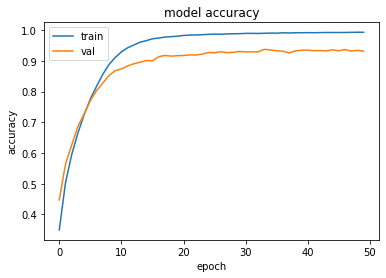

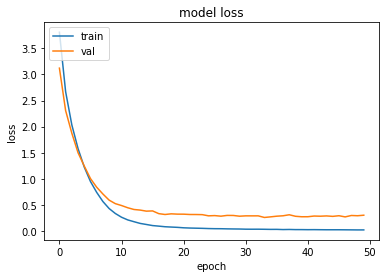

In [ ]:
from matplotlib import pyplot as plt

# plot loss and accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(PLOT_PATH.format('AE_accuracy'))
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(PLOT_PATH.format('AE_loss'))
plt.show()

**Autoencoder test**

In [21]:
from keras import *
import keras.backend as K
from keras.layers import *
from keras.models import load_model

# load model
def load_autoencoder(path):
      model = load_model(path)

      # split into encoder and decoder
      encoder = Model(model.input, model.get_layer('encoder').output)
      decoder = Model(model.get_layer('decoder_input').input, model.get_layer('decoder').output)

      # add Argmax layer to decoder to convert results to real one-hot encoding
      one_hot_to_index = Lambda(lambda x: K.cast(K.argmax(x), dtype='float32'))(decoder.output)
      decoder = Model(decoder.input, one_hot_to_index)
      return (encoder, decoder, model)

(enc, dec, model) = load_autoencoder(AE_MODEL_PATH)

As You can see below, autoencoder works really well.<br>
There are many OOV tokens which implies too small vocabulary size.

In [25]:
from tensorflow.keras.utils import to_categorical

# prints input and predicted sentence
def print_test(seq):
    seq = seq.reshape(1, 20)
    predicted = model.predict(seq)
    predicted = np.argmax(predicted, axis=2) # convert one-hot to standard encoding
    
    print("IN SENTENCE         {}".format(' '.join(dataLoader.tokenizer.sequences_to_texts(seq))))
    print("PREDICTED SENTENCE  {}".format(' '.join(dataLoader.tokenizer.sequences_to_texts(predicted))))
    print("----------------------------")

print_test(data[0])
print_test(data[15])
print_test(data[20])
print_test(data[100])
print_test(data[40000])
print_test(data[40070])
print_test(data[40051])

IN SENTENCE         effort barely <OOV> over the line . also stars anthony <OOV> e <OOV> . . saturday <OOV> 5 <OOV> video
PREDICTED SENTENCE  effort barely <OOV> over the line . also stars anthony <OOV> e <OOV> . . saturday <OOV> 5 <OOV> video
----------------------------
IN SENTENCE         some wonderful musical <OOV> . if you enjoyed thank your lucky stars and hollywood <OOV> you'll like this one .
PREDICTED SENTENCE  some wonderful musical <OOV> . if you enjoyed thank your lucky stars and hollywood <OOV> you'll like this one .
----------------------------
IN SENTENCE         for <OOV> don't bother . this movie only <OOV> in at <OOV> minutes but it feels like an <OOV> .
PREDICTED SENTENCE  for <OOV> don't bother . this movie only <OOV> in at <OOV> minutes but it feels like an <OOV> .
----------------------------
IN SENTENCE         major problem the whole group faced . everyone seems to get their life back but was it the right choice
PREDICTED SENTENCE  major problem the whole group